In [49]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
import pickle
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pandas as pd

%matplotlib inline

In [23]:
from pathlib import Path

folder_path_cars = Path('./vehicles/')
vehicles_path = [x for x in folder_path_cars.iterdir() if x.is_dir()]
cars = []

for path in vehicles_path:
    images = path.glob('*.png')
    for image  in images:
        cars.append(str(image))


folder_path_noncars = Path('./non-vehicles/')
non_vehicles_path = [x for x in folder_path_noncars.iterdir() if x.is_dir()]
notcars = []

for path in non_vehicles_path:
    images = path.glob('*.png')
    for image in images:
        notcars.append(str(image))

In [24]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 1000
random_idx = np.random.randint(0,len(cars),sample_size)
cars = np.array(cars)[random_idx]
notcars = np.array(notcars)[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
arr_orient = [5,6,7,8,9]  # HOG orientations
arr_pix_per_cell =[5,6,7,8,9] # HOG pixels per cell
arr_cell_per_block = [2,3,4] # HOG cells per block
hog_channel = "gray" # Can be 0, 1, 2, or "ALL" or "gray"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 720] # Min and max in y to search in slide_window()

n_rows_df = len(arr_orient)*len(arr_pix_per_cell)*len(arr_cell_per_block)

In [30]:
n_rows_df

75

In [31]:
Exp_data = pd.DataFrame(index=range(n_rows_df),
                        columns=['orient','pix_per_cell','cell_per_block','load_time','train_time','accuracy','len_feat'])

In [32]:
count = 0
for i in range(len(arr_orient)):
    for j in range(len(arr_pix_per_cell)):
        for k in range(len(arr_cell_per_block)):
            
            t1= time.time()
            car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=arr_orient[i], pix_per_cell=arr_pix_per_cell[j], 
                        cell_per_block=arr_cell_per_block[k], 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
            notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=arr_orient[i], pix_per_cell=arr_pix_per_cell[j], 
                        cell_per_block=arr_cell_per_block[k], 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

            X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
            # Fit a per-column scaler
            X_scaler = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler.transform(X)

            # Define the labels vector
            y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

            t2 = time.time()
            # Split up data into randomized training and test sets
            rand_state = np.random.randint(0, 100)
            X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

            print('Using:',arr_orient[i],'orientations',arr_pix_per_cell[j],'pixels per cell and',
                  arr_cell_per_block[k],'cells per block')
            print('Feature vector length:', len(X_train[0]))
            # Use a linear SVC 
            svc = LinearSVC()
            # Check the training time for the SVC            
            svc.fit(X_train, y_train)            
            accuracy = round(svc.score(X_test, y_test), 4)
            t3 = time.time()
            Exp_data.loc[count].orient = arr_orient[i]
            Exp_data.loc[count].pix_per_cell = arr_pix_per_cell[j]
            Exp_data.loc[count].cell_per_block = arr_cell_per_block[k]
            Exp_data.loc[count].load_time = t2-t1
            Exp_data.loc[count].load_time = t3-t2
            Exp_data.loc[count].accuracy = accuracy
            Exp_data.loc[count].len_feat = len(X_train[0])
            count += 1
            
            

C:\ProgramData\Anaconda3\envs\carnd-term1-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 5 orientations 5 pixels per cell and 2 cells per block
Feature vector length: 3284
Using: 5 orientations 5 pixels per cell and 3 cells per block
Feature vector length: 5364
Using: 5 orientations 5 pixels per cell and 4 cells per block
Feature vector length: 7344
Using: 5 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 2484
Using: 5 orientations 6 pixels per cell and 3 cells per block
Feature vector length: 3744
Using: 5 orientations 6 pixels per cell and 4 cells per block
Feature vector length: 4784
Using: 5 orientations 7 pixels per cell and 2 cells per block
Feature vector length: 2144
Using: 5 orientations 7 pixels per cell and 3 cells per block
Feature vector length: 3069
Using: 5 orientations 7 pixels per cell and 4 cells per block
Feature vector length: 3744
Using: 5 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1844
Using: 5 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 2484
Using: 5 o

In [33]:
Exp_data

,orient,pix_per_cell,cell_per_block,load_time,train_time,accuracy,len_feat
0,5,5,2,1.85689,NaN,0.995,3284
1,5,5,3,3.2867,NaN,0.9875,5364
2,5,5,4,0.703864,NaN,0.985,7344
3,5,6,2,1.16709,NaN,0.99,2484
4,5,6,3,1.87396,NaN,0.9875,3744
5,5,6,4,0.378002,NaN,0.97,4784
6,5,7,2,0.941495,NaN,0.99,2144
7,5,7,3,1.46688,NaN,0.9975,3069
8,5,7,4,1.88098,NaN,0.995,3744
9,5,8,2,0.696845,NaN,0.9975,1844


In [42]:
data_pix_per_cell_8 = Exp_data.loc[Exp_data.pix_per_cell == 8]

In [43]:
data_pix_per_cell_8

,orient,pix_per_cell,cell_per_block,load_time,train_time,accuracy,len_feat
9,5,8,2,0.696845,NaN,0.9975,1844
10,5,8,3,0.925452,NaN,0.995,2484
11,5,8,4,1.21522,NaN,0.985,2864
24,6,8,2,0.893367,NaN,0.9875,2040
25,6,8,3,0.760012,NaN,0.9925,2808
26,6,8,4,1.54609,NaN,0.985,3264
39,7,8,2,0.9335,NaN,0.9975,2236
40,7,8,3,1.26136,NaN,0.9875,3132
41,7,8,4,1.57417,NaN,0.995,3664
54,8,8,2,1.18616,NaN,0.9975,2432


In [44]:
len(data_pix_per_cell_8)

15

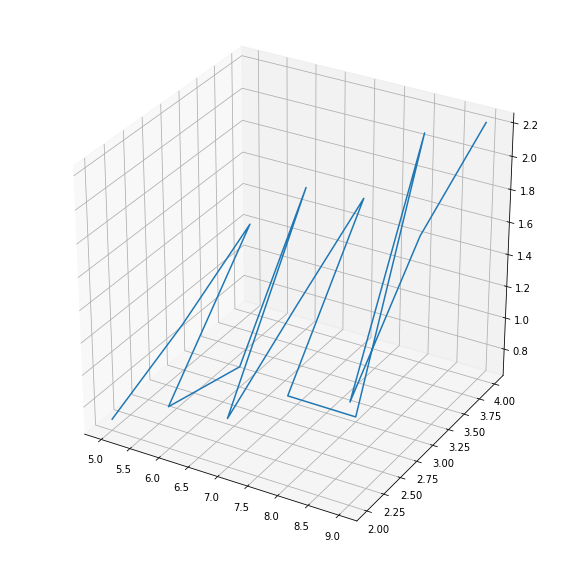

In [75]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_wireframe(data_pix_per_cell_8.orient, data_pix_per_cell_8.cell_per_block, data_pix_per_cell_8.load_time)

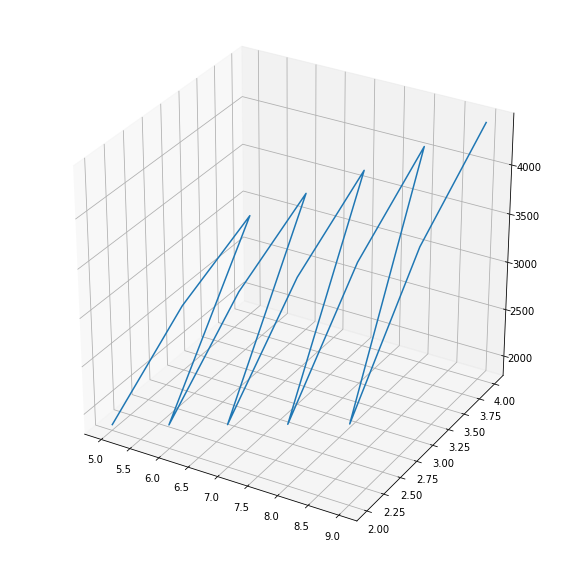

In [79]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_wireframe(data_pix_per_cell_8.orient, data_pix_per_cell_8.cell_per_block, data_pix_per_cell_8.len_feat)

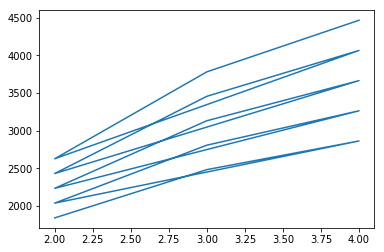

In [72]:
plt.plot(data_pix_per_cell_8.cell_per_block,data_pix_per_cell_8.len_feat)

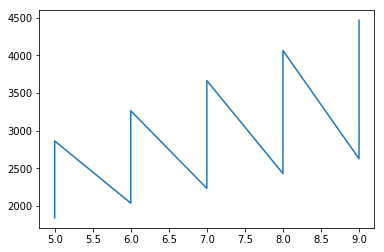

In [80]:
plt.plot(data_pix_per_cell_8.orient,data_pix_per_cell_8.len_feat)

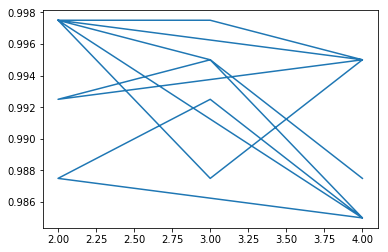

In [81]:
plt.plot(data_pix_per_cell_8.cell_per_block,data_pix_per_cell_8.accuracy)

In [82]:
data_cell_per_block_3 = Exp_data.loc[Exp_data.cell_per_block==3]

In [83]:
data_cell_per_block_3

,orient,pix_per_cell,cell_per_block,load_time,train_time,accuracy,len_feat
1,5,5,3,3.2867,NaN,0.9875,5364
4,5,6,3,1.87396,NaN,0.9875,3744
7,5,7,3,1.46688,NaN,0.9975,3069
10,5,8,3,0.925452,NaN,0.995,2484
13,5,9,3,0.788109,NaN,0.995,1989
16,6,5,3,4.2312,NaN,0.985,6264
19,6,6,3,2.3051,NaN,0.9875,4320
22,6,7,3,1.84388,NaN,0.985,3510
25,6,8,3,0.760012,NaN,0.9925,2808
28,6,9,3,1.03874,NaN,0.9975,2214


In [84]:
len(data_cell_per_block_3)

25

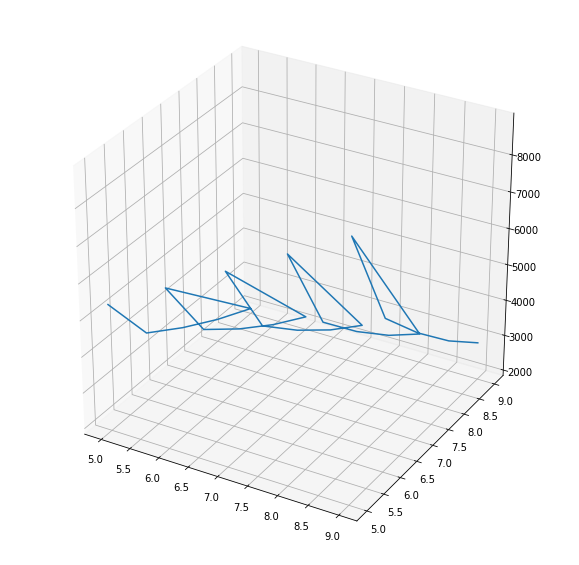

In [88]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_wireframe(data_cell_per_block_3.orient, data_cell_per_block_3.pix_per_cell, data_cell_per_block_3.len_feat)

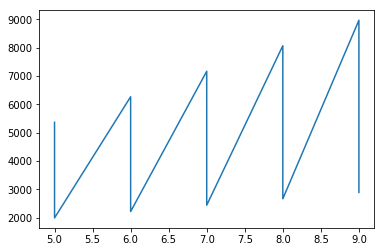

In [89]:
plt.plot(data_cell_per_block_3.orient,data_cell_per_block_3.len_feat)

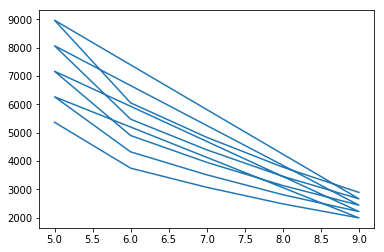

In [90]:
plt.plot(data_cell_per_block_3.pix_per_cell,data_cell_per_block_3.len_feat)